In [1]:
!date +%F

2019-04-25


In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.manifold

In [3]:
print(sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scipy version:', scipy.__version__)
print('sklearn version:', sklearn.__version__)

3.7.3 (default, Apr 19 2019, 19:12:31) 
[Clang 10.0.1 (clang-1001.0.46.4)]
numpy version: 1.16.2
pandas version: 0.24.2
scipy version: 1.2.1
sklearn version: 0.20.3


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
print('matplotlib version:', mpl.__version__)
print('seaborn version:', sns.__version__)

matplotlib version: 3.0.3
seaborn version: 0.9.0


In [6]:
# set pdf.fonttype to 42 (TrueType), editable texts in Illustrator
mpl.rcParams['pdf.fonttype'] = 42
# set fonts
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
# mpl.rcParams['figure.dpi'] = mpl.rcParams['figure.dpi'] * 1.5

In [7]:
import umap
print('umap version:', umap.__version__)

umap version: 0.3.8


In [8]:
from fast_tsne import fast_tsne

# Data loading

In [9]:
# load cells
cells_included = np.load('../../data/drop-seq/expr_readcount_norm_log_corrected_scaled_dimnames.npy')[1]
cells_included

array(['JD126-1-2_TTTCTATATACA.bam', 'JD126-1-2_CCTAGAAACCAG.bam',
       'JD126-1-2_TCATAGTCTATT.bam', ..., 'JD135Y_CCGATATGGTCT.bam',
       'JD135Y_ATGTGAGGATTG.bam', 'JD135Y_ATGCCCCGCGTC.bam'], dtype='<U26')

In [10]:
# load clustering
tsne_out_coords = pd.read_csv('../../data/drop-seq/tsne_out_coords.txt', index_col=0)

In [11]:
# load PCA result
%time mat = np.load('../../data/drop-seq/pca_out_x.npy')[:,0:10]
mat.shape

CPU times: user 1.38 ms, sys: 2.99 s, total: 2.99 s
Wall time: 4.29 s


(25776, 10)

# Visualization

In [12]:
embedding_fitsne = tsne_out_coords[['cluster' ,'num.umis', 'num.reads']].copy(deep=True)
embedding_fitsne.shape

(25776, 3)

In [13]:
sns.set()

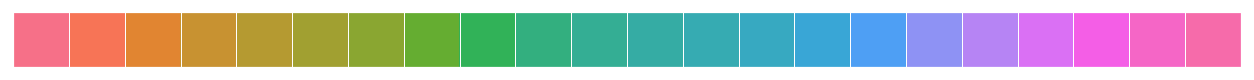

In [14]:
cluster_colors = sns.color_palette("husl", embedding_fitsne['cluster'].unique().shape[0])
sns.palplot(cluster_colors)

In [15]:
embedding_fitsne['color'] = embedding_fitsne['cluster'].map({i + 1:j for i, j in enumerate(cluster_colors)})
embedding_fitsne.head()

cluster  num.umis  num.reads  \
JD126-1-2_TTTCTATATACA.bam        9     18437      23692   
JD126-1-2_CCTAGAAACCAG.bam        9     16103      20274   
JD126-1-2_TCATAGTCTATT.bam        9     15542      20525   
JD126-1-2_ATGACCTTTCCC.bam       13     14783      17798   
JD126-1-2_CATTAGTGATGG.bam       11     13701      16388   

                                                                        color  
JD126-1-2_TTTCTATATACA.bam  (0.19592059105779686, 0.6981620017487838, 0.34...  
JD126-1-2_CCTAGAAACCAG.bam  (0.19592059105779686, 0.6981620017487838, 0.34...  
JD126-1-2_TCATAGTCTATT.bam  (0.19592059105779686, 0.6981620017487838, 0.34...  
JD126-1-2_ATGACCTTTCCC.bam  (0.21420912437215422, 0.6714963557258681, 0.69...  
JD126-1-2_CATTAGTGATGG.bam  (0.2067117296964458, 0.6829103404254792, 0.582...

## perplexity

In [16]:
embedding_fitsne_perplexity = embedding_fitsne.copy(deep=True)

In [17]:
perplexities = [5, 10, 15, 20, 30, 50, 100, 200]

In [18]:
for i in perplexities:
    print('Calculating perplexity: {} ... '.format(i),
          end='')

    u = fast_tsne(X=mat,
                  map_dims=2, 
                  perplexity=i,
                  seed=20190212,
                  max_iter=2000,
                  df=1.0)
    print('Done!')
    
    embedding_fitsne_perplexity.loc[:, 'perplexity_' + str(i) + '_x'] = u[:,0]
    embedding_fitsne_perplexity.loc[:, 'perplexity_' + str(i) + '_y'] = u[:,1]

Calculating perplexity: 5 ... Done!
Calculating perplexity: 10 ... Done!
Calculating perplexity: 15 ... Done!
Calculating perplexity: 20 ... Done!
Calculating perplexity: 30 ... Done!
Calculating perplexity: 50 ... Done!
Calculating perplexity: 100 ... Done!
Calculating perplexity: 200 ... Done!


In [19]:
if not Path('embedding_fitsne_perplexity.csv').is_file():
    embedding_fitsne_perplexity.to_csv('embedding_fitsne_perplexity.csv')    

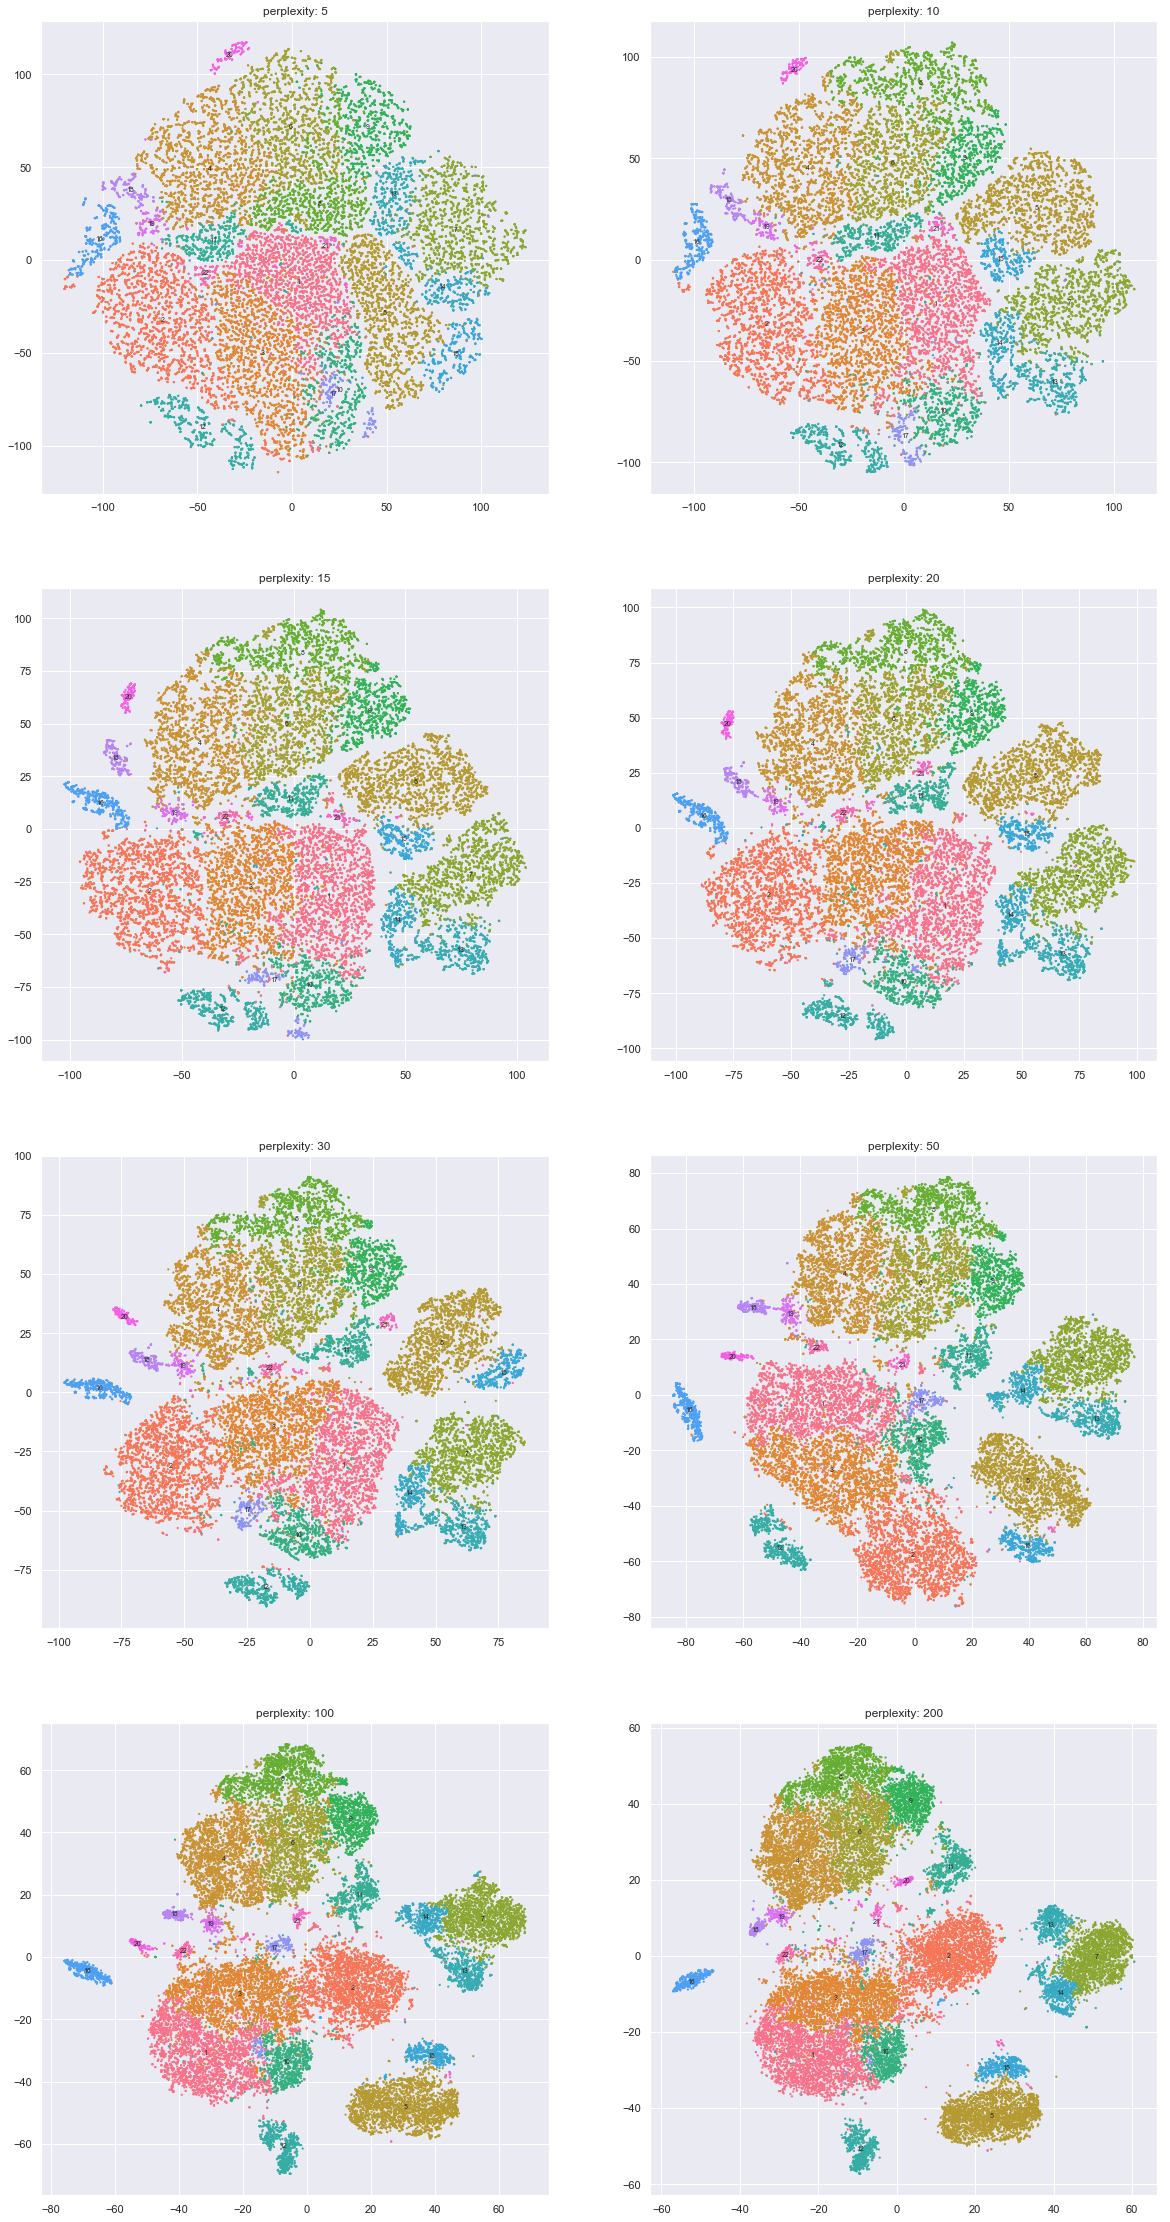

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 40))

for j, i in enumerate([ii for i in axes for ii in i]):
    
    i.scatter(x=embedding_fitsne_perplexity['perplexity_' + str(perplexities[j]) + '_x'],
              y=embedding_fitsne_perplexity['perplexity_' + str(perplexities[j]) + '_y'],
              c=embedding_fitsne_perplexity['color'],
              s=20,
              marker='.',
              linewidth=0)

    for ii in sorted(embedding_fitsne_perplexity['cluster'].unique()):
        i.annotate(s=ii,
                   xy=(embedding_fitsne_perplexity.loc[embedding_fitsne_perplexity.cluster == ii,
                                                       'perplexity_' + str(perplexities[j]) + '_x'].median(),
                       embedding_fitsne_perplexity.loc[embedding_fitsne_perplexity.cluster == ii,
                                                       'perplexity_' + str(perplexities[j]) + '_y'].median()),
                   fontsize=7,
                   horizontalalignment='center',
                   verticalalignment='center')

    i.set_title('perplexity: {}'.format(str(perplexities[j])))   

In [21]:
if not Path('embedding_fitsne_perplexity.pdf').is_file():
    fig.savefig('embedding_fitsne_perplexity.pdf', transparent=False)

## df

In [22]:
embedding_fitsne_df = embedding_fitsne.copy(deep=True)

In [23]:
dfs = [100.0, 10.0, 1.0, 0.9, 0.7, 0.5]

In [24]:
for i in dfs:
    print('Calculating df: {} ... '.format(i),
          end='')

    u = fast_tsne(X=mat,
                  map_dims=2, 
                  perplexity=30,
                  seed=20190212,
                  max_iter=2000,
                  df=i)
    print('Done!')

    embedding_fitsne_df.loc[:, 'df_' + str(i) + '_x'] = u[:,0]
    embedding_fitsne_df.loc[:, 'df_' + str(i) + '_y'] = u[:,1]

Calculating df: 100.0 ... Done!
Calculating df: 10.0 ... Done!
Calculating df: 1.0 ... Done!
Calculating df: 0.9 ... Done!
Calculating df: 0.7 ... Done!
Calculating df: 0.5 ... Done!


In [25]:
if not Path('embedding_fitsne_df.csv').is_file():
    embedding_fitsne_df.to_csv('embedding_fitsne_df.csv')    

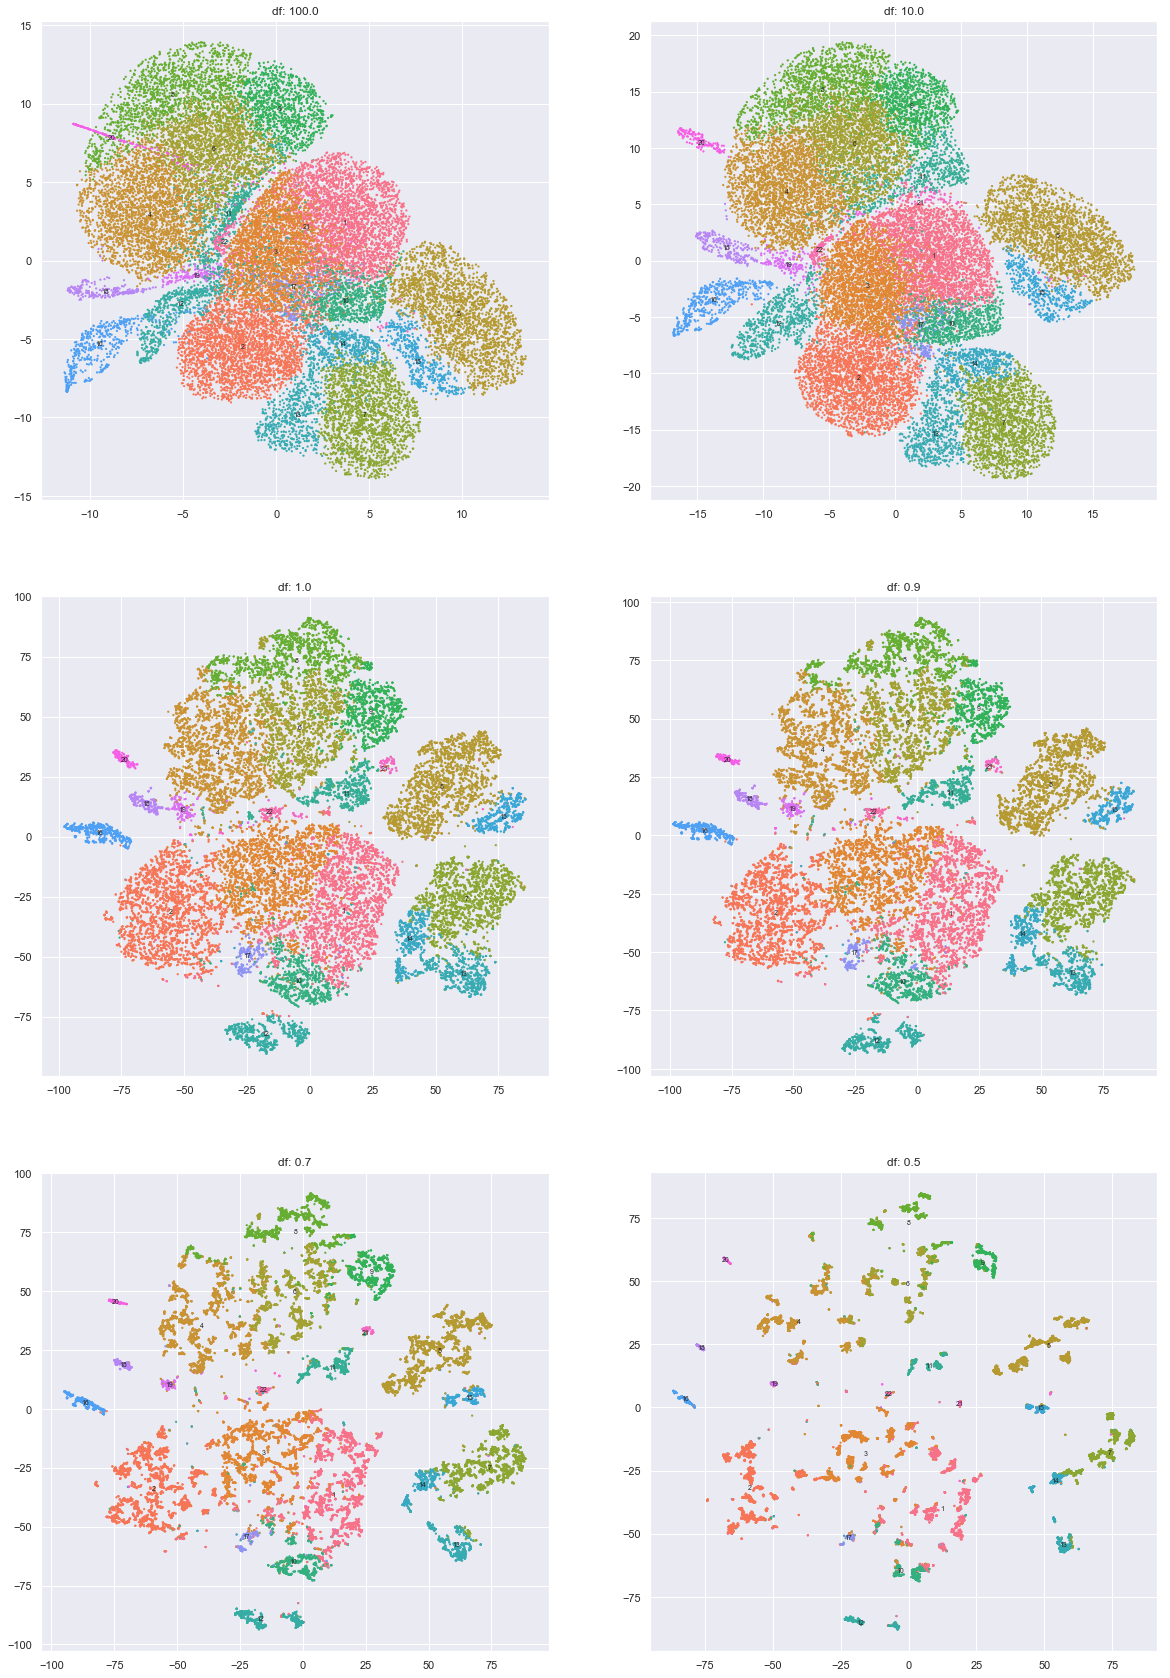

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30))

for j, i in enumerate([ii for i in axes for ii in i]):
    
    i.scatter(x=embedding_fitsne_df['df_' + str(dfs[j]) + '_x'],
              y=embedding_fitsne_df['df_' + str(dfs[j]) + '_y'],
              c=embedding_fitsne_df['color'],
              s=20,
              marker='.',
              linewidth=0)

    for ii in sorted(embedding_fitsne_df['cluster'].unique()):
        i.annotate(s=ii,
                   xy=(embedding_fitsne_df.loc[embedding_fitsne_df.cluster == ii,
                                               'df_' + str(dfs[j]) + '_x'].median(),
                       embedding_fitsne_df.loc[embedding_fitsne_df.cluster == ii,
                                               'df_' + str(dfs[j]) + '_y'].median()),
                   fontsize=7,
                   horizontalalignment='center',
                   verticalalignment='center')

    i.set_title('df: {}'.format(str(dfs[j])))

In [27]:
if not Path('embedding_fitsne_df.pdf').is_file():
    fig.savefig('embedding_fitsne_df.pdf', transparent=False)

# Refinement of visualization

In [28]:
embedding_fitsne.head()

cluster  num.umis  num.reads  \
JD126-1-2_TTTCTATATACA.bam        9     18437      23692   
JD126-1-2_CCTAGAAACCAG.bam        9     16103      20274   
JD126-1-2_TCATAGTCTATT.bam        9     15542      20525   
JD126-1-2_ATGACCTTTCCC.bam       13     14783      17798   
JD126-1-2_CATTAGTGATGG.bam       11     13701      16388   

                                                                        color  
JD126-1-2_TTTCTATATACA.bam  (0.19592059105779686, 0.6981620017487838, 0.34...  
JD126-1-2_CCTAGAAACCAG.bam  (0.19592059105779686, 0.6981620017487838, 0.34...  
JD126-1-2_TCATAGTCTATT.bam  (0.19592059105779686, 0.6981620017487838, 0.34...  
JD126-1-2_ATGACCTTTCCC.bam  (0.21420912437215422, 0.6714963557258681, 0.69...  
JD126-1-2_CATTAGTGATGG.bam  (0.2067117296964458, 0.6829103404254792, 0.582...

In [29]:
embedding_fitsne_init = embedding_fitsne.copy(deep=True)

## PCA initialization

In [30]:
init_pca = mat[:,:2]
init_pca.shape

(25776, 2)

In [31]:
embedding_fitsne_init.loc[:, 'x_init_pca'] = mat[:,0]
embedding_fitsne_init.loc[:, 'y_init_pca'] = mat[:,1]

In [32]:
# u = fitsne.FItSNE(X=mat.copy(order='C'),
#                   no_dims=2, 
#                   perplexity=30,
#                   initialization=None,
#                   rand_seed=20190212,
#                   max_iter=2000)

# embedding_fitsne_init.loc[:, 'perplexity30_x'] = u[:,0]
# embedding_fitsne_init.loc[:, 'perplexity30_y'] = u[:,1]

In [33]:
u = fast_tsne(X=mat,
              map_dims=2, 
              perplexity=5,
              initialization=init_pca,
              seed=20190212,
              max_iter=2000,
              df=1.0)

embedding_fitsne_init.loc[:, 'perplexity5_x_init_pca'] = u[:,0]
embedding_fitsne_init.loc[:, 'perplexity5_y_init_pca'] = u[:,1]

In [34]:
u = fast_tsne(X=mat,
              map_dims=2, 
              perplexity=30,
              initialization=init_pca,
              seed=20190212,
              max_iter=2000,
              df=1.0)

embedding_fitsne_init.loc[:, 'perplexity30_x_init_pca'] = u[:,0]
embedding_fitsne_init.loc[:, 'perplexity30_y_init_pca'] = u[:,1]

In [35]:
u = fast_tsne(X=mat,
              map_dims=2, 
              perplexity=50,
              initialization=init_pca,
              seed=20190212,
              max_iter=2000,
              df=1.0)

embedding_fitsne_init.loc[:, 'perplexity50_x_init_pca'] = u[:,0]
embedding_fitsne_init.loc[:, 'perplexity50_y_init_pca'] = u[:,1]

In [36]:
u = fast_tsne(X=mat,
              map_dims=2, 
              perplexity=500,
              initialization=init_pca,
              seed=20190212,
              max_iter=2000,
              df=1.0)

embedding_fitsne_init.loc[:, 'perplexity500_x_init_pca'] = u[:,0]
embedding_fitsne_init.loc[:, 'perplexity500_y_init_pca'] = u[:,1]

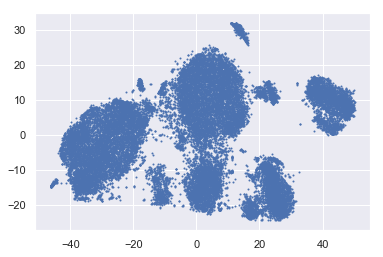

In [37]:
plt.scatter(u[:,0], u[:,1], s=1)

## UMAP initialization

In [38]:
np.random.seed(seed=20190212)
init_umap = umap.UMAP(n_neighbors=10,
                      n_components=2,
                      metric='euclidean',
                      min_dist=0.1,
                      verbose=True).fit_transform(mat)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=10, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


In [39]:
init_umap.shape

(25776, 2)

In [40]:
init_umap = init_umap.astype(np.double)

In [41]:
embedding_fitsne_init.loc[:, 'x_init_umap'] = u[:,0]
embedding_fitsne_init.loc[:, 'y_init_umap'] = u[:,1]

In [42]:
u = fast_tsne(X=mat,
              map_dims=2, 
              perplexity=5,
              initialization=init_umap,
              seed=20190212,
              max_iter=2000,
              df=1.0)

embedding_fitsne_init.loc[:, 'perplexity5_x_init_umap'] = u[:,0]
embedding_fitsne_init.loc[:, 'perplexity5_y_init_umap'] = u[:,1]

In [43]:
u = fast_tsne(X=mat,
              map_dims=2, 
              perplexity=30,
              initialization=init_umap,
              seed=20190212,
              max_iter=2000,
              df=1.0)

embedding_fitsne_init.loc[:, 'perplexity30_x_init_umap'] = u[:,0]
embedding_fitsne_init.loc[:, 'perplexity30_y_init_umap'] = u[:,1]

In [44]:
u = fast_tsne(X=mat,
              map_dims=2, 
              perplexity=50,
              initialization=init_umap,
              seed=20190212,
              max_iter=2000,
              df=1.0)

embedding_fitsne_init.loc[:, 'perplexity50_x_init_umap'] = u[:,0]
embedding_fitsne_init.loc[:, 'perplexity50_y_init_umap'] = u[:,1]

In [45]:
u = fast_tsne(X=mat,
              map_dims=2, 
              perplexity=500,
              initialization=init_umap,
              seed=20190212,
              max_iter=2000,
              df=1.0)

embedding_fitsne_init.loc[:, 'perplexity500_x_init_umap'] = u[:,0]
embedding_fitsne_init.loc[:, 'perplexity500_y_init_umap'] = u[:,1]

In [46]:
if not Path('embedding_fitsne_init.csv').is_file():
    embedding_fitsne_init.to_csv('embedding_fitsne_init.csv')

In [47]:
columns_x = ['x_init_pca',
             'x_init_umap',
             'perplexity5_x_init_pca',
             'perplexity5_x_init_umap',
             'perplexity30_x_init_pca',
             'perplexity30_x_init_umap',
             'perplexity50_x_init_pca',
             'perplexity50_x_init_umap',
             'perplexity500_x_init_pca',
             'perplexity500_x_init_umap']

columns_y = [i.replace('x_', 'y_') for  i in columns_x]

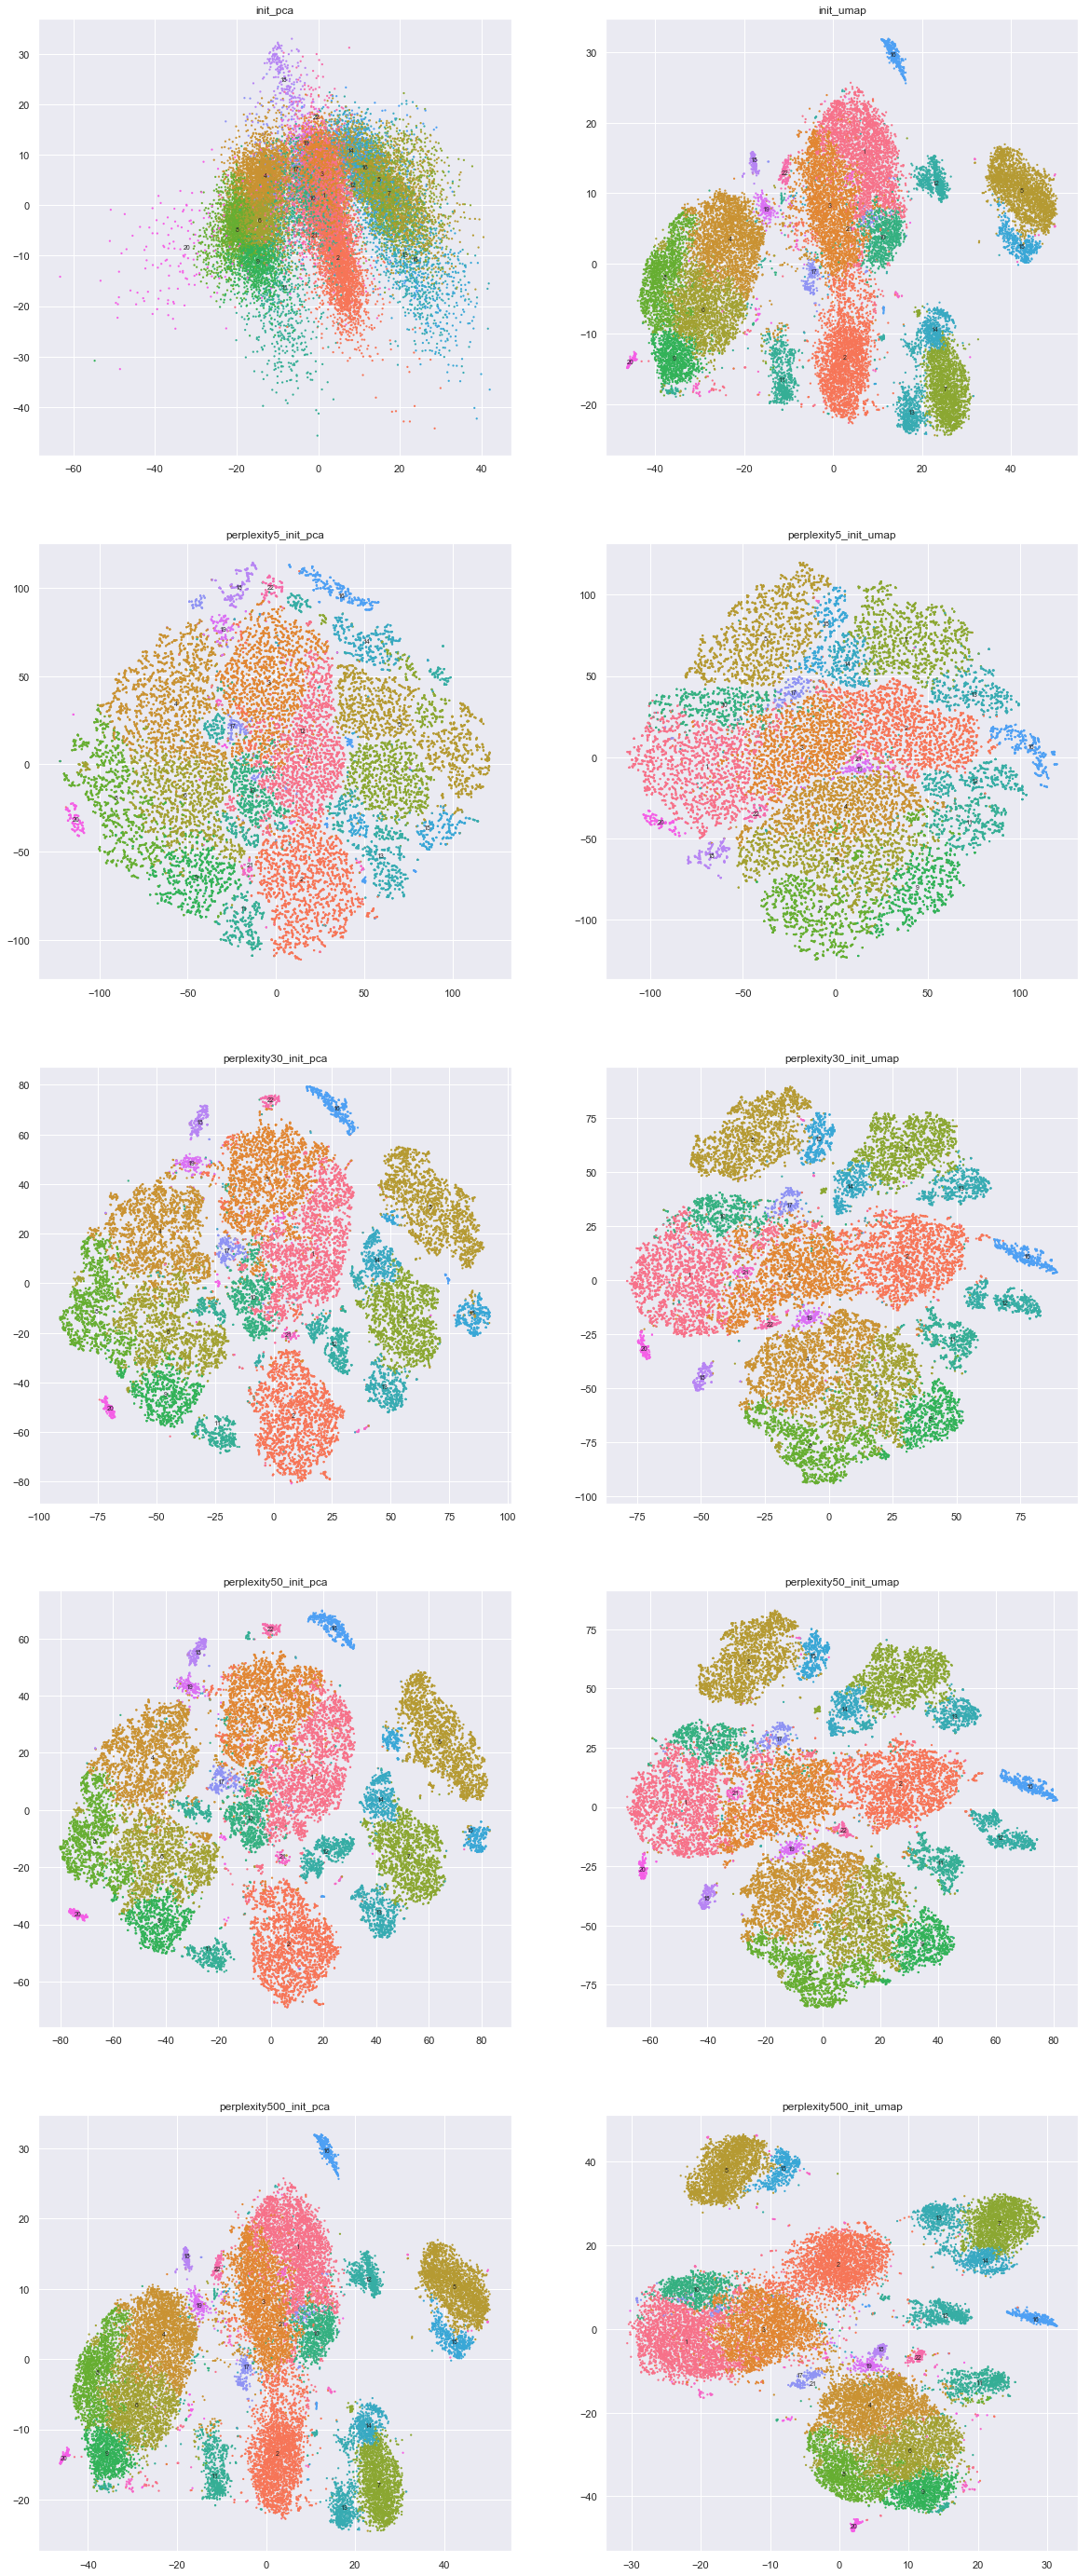

In [48]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 50))

for j,i in enumerate([ii  for i in axes for ii in i]):

    i.scatter(x=embedding_fitsne_init.loc[:, columns_x[j]],
              y=embedding_fitsne_init.loc[:, columns_y[j]],
              c=embedding_fitsne_init['color'],
              s=20,
              marker='.',
              linewidth=0)
    
    for ii in sorted(embedding_fitsne_init['cluster'].unique()):
        i.annotate(s=ii,
                   xy=(embedding_fitsne_init.groupby('cluster').median()[columns_x[j]][ii],
                       embedding_fitsne_init.groupby('cluster').median()[columns_y[j]][ii]),
                   fontsize=7,
                   horizontalalignment='center',
                   verticalalignment='center')
    i.set_title(columns_x[j].replace('x_', ''))

In [49]:
if not Path('embedding_fitsne_init.pdf').is_file():
    fig.savefig('embedding_fitsne_init.pdf', transparent=False)